## Imports

In [28]:
import numpy as np
from tqdm import trange

from kuramoto import Kuramoto
from kuramoto.db_metrics import *

from NNetwork import NNetwork as nn
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import svm
from sklearn import metrics, model_selection
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA ### Use truncated SVD / online PCA later for better computational efficiency

import warnings
warnings.filterwarnings("ignore")

## Plotting Functions

#### 1. Display Graphs

In [2]:
def display_graphs(title,
                     save_path,
                     grid_shape=[2,3],
                     fig_size=[10,10],
                     data = None, # [X, embs]
                     show_importance=False):

        # columns of X = vectorized k x k adjacency matrices
        # corresponding list in embs = sequence of nodes (may overalp)
        X, embs = data
        print('X.shape', X.shape)

        rows = grid_shape[0]
        cols = grid_shape[1]

        fig = plt.figure(figsize=fig_size, constrained_layout=False)
        # make outer gridspec

        idx = np.arange(X.shape[1])
        outer_grid = gridspec.GridSpec(nrows=rows, ncols=cols, wspace=0.02, hspace=0.02)

        # make nested gridspecs
        for i in range(rows * cols):
            a = i // cols
            b = i % rows

            Ndict_wspace = 0.05
            Ndict_hspace = 0.05

            # display graphs
            inner_grid = outer_grid[i].subgridspec(1, 1, wspace=Ndict_wspace, hspace=Ndict_hspace)

            # get rid of duplicate nodes
            A = X[:,idx[i]]
            A = X[:,idx[i]].reshape(int(np.sqrt(X.shape[0])), -1)
            H = nn.NNetwork()
            H.read_adj(A, embs[idx[i]])
            A_sub = H.get_adjacency_matrix()

            # read in as a nx graph for plotting
            G1 = nx.from_numpy_matrix(A_sub)
            ax = fig.add_subplot(inner_grid[0, 0])
            pos = nx.spring_layout(G1)
            edges = G1.edges()
            weights = [1*G1[u][v]['weight'] for u,v in edges]
            nx.draw(G1, with_labels=False, node_size=20, ax=ax, width=weights, label='Graph')

            ax.set_xticks([])
            ax.set_yticks([])

        plt.suptitle(title, fontsize=15)
        fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0)
        fig.savefig(save_path, bbox_inches='tight')

#### 2. Display Dictionaries

In [3]:
def display_dictionary(W, dictionary_shape=None ,save_name=None, score=None, grid_shape=None, figsize=[10,10]):
    
    if dictionary_shape is None:
        k = int(np.sqrt(W.shape[0]))
        dict_shape = (k,k)
    else:
        dict_shape = dictionary_shape
        
    rows = int(np.sqrt(W.shape[1]))
    cols = int(np.sqrt(W.shape[1]))
    if grid_shape is not None:
        rows = grid_shape[0]
        cols = grid_shape[1]
    
    figsize0=figsize
    if (score is None) and (grid_shape is not None):
        figsize0=(cols, rows)
    if (score is not None) and (grid_shape is not None):
        figsize0=(cols, rows+0.2)
    
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=figsize0,
                            subplot_kw={'xticks': [], 'yticks': []})
        
        
    for ax, i in zip(axs.flat, range(100)):
        if score is not None:
            idx = np.argsort(score)
            idx = np.flip(idx)    
            
            ax.imshow(W.T[idx[i]].reshape(dict_shape), cmap="viridis", interpolation='nearest')
            ax.set_xlabel('%1.2f' % score[i], fontsize=13)  # get the largest first
            ax.xaxis.set_label_coords(0.5, -0.05)
        else: 
            ax.imshow(W.T[i].reshape(dict_shape), cmap="viridis", interpolation='nearest')
            if score is not None:
                ax.set_xlabel('%1.2f' % score[i], fontsize=13)  # get the largest first
                ax.xaxis.set_label_coords(0.5, -0.05)
       
    plt.tight_layout()
    # plt.suptitle('Dictionary learned from patches of size %d' % k, fontsize=16)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
    
    if save_name is not None:
        plt.savefig( save_name, bbox_inches='tight')
    plt.show()

#### 3. Display both Graphs and Dictionaries

In [4]:
def display_dict_and_graph(title,
                           W,
                           singular_values, 
                           save_path,
                           grid_shape=None,
                           fig_size=[10,10],
                           show_importance=False,
                           only_show_matrices=True):
        
        n_components = W.shape[1]
        k = int(np.sqrt(W.shape[0]))

        rows = np.round(np.sqrt(n_components))
        rows = rows.astype(int)
        if grid_shape is not None:
            rows = grid_shape[0]
            cols = grid_shape[1]
        else:
            if rows ** 2 == n_components:
                cols = rows
            else:
                cols = rows + 1

        if show_importance:
            # importance = np.sum(self.code, axis=1) / sum(sum(self.code))
            idx = np.argsort(singular_values)
            idx = np.flip(idx)
        else:
            idx = np.arange(W.shape[1])

        Ndict_wspace = 0.05
        Ndict_hspace = 0.05

        fig = plt.figure(figsize=fig_size, constrained_layout=False)
        ncols = 2 
        if only_show_matrices:
            ncols = 1
        outer_grid = gridspec.GridSpec(nrows=1, ncols=ncols, wspace=0.02, hspace=0.02)
        for t in np.arange(2):
            # make nested gridspecs

            if t == 0:
                ### Make gridspec
                inner_grid = outer_grid[t].subgridspec(rows, cols, wspace=Ndict_wspace, hspace=Ndict_hspace)
                #gs1 = fig.add_gridspec(nrows=rows, ncols=cols, wspace=0.05, hspace=0.05)

                for i in range(rows * cols):
                    a = i // cols
                    b = i % cols
                    ax = fig.add_subplot(inner_grid[a, b])
                    ax.imshow(W.T[idx[i]].reshape(k, k), cmap="viridis", interpolation='nearest')
                    # ax.set_xlabel('%1.2f' % importance[idx[i]], fontsize=13)  # get the largest first
                    # ax.xaxis.set_label_coords(0.5, -0.05)  # adjust location of importance appearing beneath patches
                    ax.set_xticks([])
                    ax.set_yticks([])
            if (t == 1) and not only_show_matrices:
                inner_grid = outer_grid[t].subgridspec(rows, cols, wspace=Ndict_wspace, hspace=Ndict_hspace)
                #gs1 = fig.add_gridspec(nrows=rows, ncols=cols, wspace=0.05, hspace=0.05)

                for i in range(rows * cols):
                    a = i // cols
                    b = i % cols

                    G1 = nx.from_numpy_matrix(W[:,idx[i]].reshape(int(np.sqrt(W.shape[0])),-1))
                    ax = fig.add_subplot(inner_grid[a, b])
                    pos = nx.spring_layout(G1)
                    edges = G1.edges()
                    weights = [2*G1[u][v]['weight'] for u,v in edges]
                    nx.draw(G1, with_labels=False, node_size=10, ax=ax, width=weights, label='Graph')
                    if show_importance:
                        ax.set_xlabel('%1.2f' % importance[idx[i]], fontsize=13)  # get the largest first
                        ax.xaxis.set_label_coords(0.5, -0.05)  # adjust location of importance appearing beneath patches

                    ax.set_xticks([])
                    ax.set_yticks([])

        if title is not None:
            plt.suptitle(title, fontsize=25)
        fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0)
        fig.savefig(save_path, bbox_inches='tight')

## NMF Functions

In [5]:
def coding(X, W, H0, 
          r=None, 
          a1=0, #L1 regularizer
          a2=0, #L2 regularizer
          sub_iter=[5], 
          stopping_grad_ratio=0.0001, 
          nonnegativity=True,
          subsample_ratio=1):
    """
    Find \hat{H} = argmin_H ( || X - WH||_{F}^2 + a1*|H| + a2*|H|_{F}^{2} ) within radius r from H0
    Use row-wise projected gradient descent
    """
    H1 = H0.copy()
    i = 0
    dist = 1
    idx = np.arange(X.shape[1])
    if subsample_ratio>1:  # subsample columns of X and solve reduced problem (like in SGD)
        idx = np.random.randint(X.shape[1], size=X.shape[1]//subsample_ratio)
    A = W.T @ W ## Needed for gradient computation
    grad = W.T @ (W @ H0 - X)
    while (i < np.random.choice(sub_iter)):
        step_size = (1 / (((i + 1) ** (1)) * (np.trace(A) + 1)))
        H1 -= step_size * grad 
        if nonnegativity:
            H1 = np.maximum(H1, 0)  # nonnegativity constraint
        i = i + 1
    return H1


def ALS(X,
        n_components = 10, # number of columns in the dictionary matrix W
        n_iter=100,
        a0 = 0, # L1 regularizer for H
        a1 = 0, # L1 regularizer for W
        a12 = 0, # L2 regularizer for W
        H_nonnegativity=True,
        W_nonnegativity=True,
        compute_recons_error=False,
        subsample_ratio = 10):
    
        '''
        Given data matrix X, use alternating least squares to find factors W,H so that 
                                || X - WH ||_{F}^2 + a0*|H|_{1} + a1*|W|_{1} + a12 * |W|_{F}^{2}
        is minimized (at least locally)
        '''
        
        d, n = X.shape
        r = n_components
        
        #normalization = np.linalg.norm(X.reshape(-1,1),1)/np.product(X.shape) # avg entry of X
        #print('!!! avg entry of X', normalization)
        #X = X/normalization

        # Initialize factors 
        W = np.random.rand(d,r)
        H = np.random.rand(r,n) 
        # H = H * np.linalg.norm(X) / np.linalg.norm(H)
        for i in trange(n_iter):
            #H = coding_within_radius(X, W.copy(), H.copy(), a1=a0, nonnegativity=H_nonnegativity, subsample_ratio=subsample_ratio)
            #W = coding_within_radius(X.T, H.copy().T, W.copy().T, a1=a1, a2=a12, nonnegativity=W_nonnegativity, subsample_ratio=subsample_ratio).T
            H = coding(X, W.copy(), H.copy(), a1=a0, nonnegativity=H_nonnegativity, subsample_ratio=subsample_ratio)
            W = coding(X.T, H.copy().T, W.copy().T, a1=a1, a2=a12, nonnegativity=W_nonnegativity, subsample_ratio=subsample_ratio).T
            W /= np.linalg.norm(W)
            if compute_recons_error and (i % 10 == 0) :
                print('iteration %i, reconstruction error %f' % (i, np.linalg.norm(X-W@H)**2))
        return W, H

## Network Sampling - Caltech

In [207]:
sampling_alg = 'pivot'

ntwk = 'Caltech36' # COVID_PPI, Wisconsin87, UCLA26
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
save_folder = 'images/'
k = 25

path = "../Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

num nodes in G 769
num edges in G 33312


num of subgraphs induced on k-paths: 400
X.shape (625, 400)


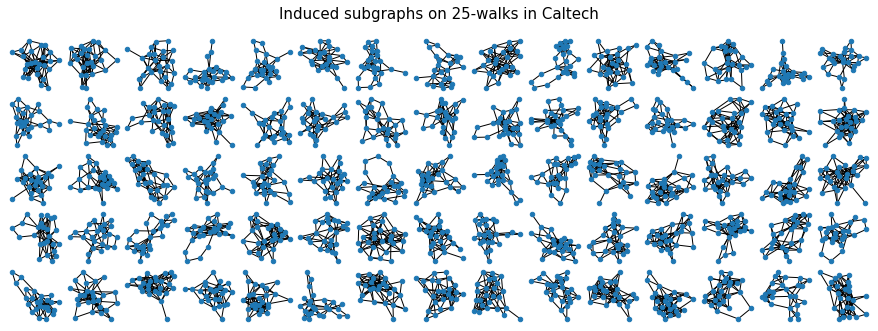

In [208]:
X, embs = G.get_patches(k=k, sample_size=400, skip_folded_hom=True)

display_graphs(title='Induced subgraphs on {}-walks in {}'.format(k, ntwk_nonumber),
                 save_path=save_folder + ntwk_nonumber + "_subgraphs_"+ str(sampling_alg) + "_walk", 
                 data = [X, embs],
                 grid_shape = [5, 15],
                 fig_size = [15, 5],
                 show_importance=False)

In [209]:
def generate_nxg(get_patches_X):
    
    graph_list = []
    for i in range(X.shape[1]):
        adj_mat = X.T[i].reshape(25,25)
        G = nx.from_numpy_matrix(adj_mat)
        graph_list.append(G)
    
    return graph_list

def synchronization(colors):
    ordered = list(np.pi - colors); ordered.sort()
    lordered = len(ordered)
    
    threshold = np.pi
    if ordered == 0:
        assert("Empty array or logic error.")
    elif lordered == 1:
        return (0 < threshold)
    elif lordered == 2:
        dw = ordered[1]-ordered[0]
        if dw > threshold:
            return ((2*np.pi - dw) < threshold)
        else:
            return (dw < threshold)
    else:
        widths = [2*np.pi+ordered[0]-ordered[-1]]
        for i in range(lordered-1):
            widths.append(ordered[i+1]-ordered[i])
        return (np.abs(2*np.pi - max(widths)) < threshold)

In [210]:
graph_list = generate_nxg(X)
print(f"num of graphs: {len(graph_list)}")

num of graphs: 400


In [211]:
nodes = int(np.sqrt(X.shape[0]))
r = 25
df = pd.DataFrame()
K = 2.5

for G in graph_list:
    
    headers = []
    for i in range(1, nodes+1):
        for j in range(1, r+1):
            headers.append(f's{i}_{j}')
        
    df1 = pd.DataFrame(columns=['# Edges', '# Nodes', 'Min Degree', 'Max Degree', 'Diameter', 'Synchronized'])
    temp = pd.DataFrame()
        
    if nx.is_connected(G):
        edges = G.number_of_edges()
        nodes = G.number_of_nodes()

        degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
        dmax = max(degree_sequence)
        dmin = min(degree_sequence)

        diam = nx.diameter(G)

        # Applying Kuramoto
        adj_mat = nx.to_numpy_array(G)
        model = Kuramoto(coupling=K, dt=0.01, T=18, n_nodes=nodes, base_iter=r, half_sync=False)

        sim = model.run(adj_mat)
        arr = sim.T[-1]
        conc = synchronization(arr)
            
        df1.at[len(df1.index)] = [edges, nodes, dmin, dmax, diam, conc]

        df2 = pd.DataFrame(sim[:,:r].flatten(order='C')).T
        df2.columns = headers
            
        temp = pd.concat([df2, df1], axis=1)

        df = pd.concat([df, temp], ignore_index=True)
    
df

,s1_1,s1_2,s1_3,s1_4,s1_5,s1_6,s1_7,s1_8,s1_9,s1_10,...,s25_22,s25_23,s25_24,s25_25,# Edges,# Nodes,Min Degree,Max Degree,Diameter,Synchronized
0,1.102859,1.106992,1.111084,1.115135,1.119144,1.123112,1.127039,1.130925,1.134772,1.138579,...,1.164124,1.170160,1.176302,1.182551,85,25,3,15,3,True
1,5.941678,5.932094,5.922669,5.913404,5.904300,5.895358,5.886581,5.877969,5.869525,5.861249,...,1.864060,1.837482,1.810803,1.784028,84,25,2,14,4,False
2,1.921082,1.922253,1.923401,1.924529,1.925642,1.926743,1.927835,1.928923,1.930010,1.931100,...,4.883023,4.891421,4.899661,4.907746,63,25,1,11,4,True
3,0.436744,0.420135,0.404720,0.390469,0.377347,0.365315,0.354334,0.344362,0.335355,0.327272,...,4.851532,4.855128,4.858851,4.862697,60,25,1,10,5,False
4,0.764175,0.778214,0.792461,0.806917,0.821583,0.836460,0.851547,0.866846,0.882357,0.898080,...,6.249760,6.260695,6.271874,0.000117,63,25,1,10,5,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,2.667600,2.675503,2.683501,2.691599,2.699800,2.708109,2.716530,2.725068,2.733725,2.742507,...,5.510744,5.513945,5.517296,5.520795,75,25,2,13,4,False
396,4.268391,4.260396,4.252232,4.243894,4.235380,4.226687,4.217814,4.208756,4.199513,4.190080,...,1.873139,1.883797,1.894488,1.905209,71,25,2,14,4,True
397,5.666232,5.691596,5.716339,5.740462,5.763965,5.786847,5.809111,5.830759,5.851796,5.872224,...,0.559886,0.565955,0.572073,0.578239,74,25,1,14,4,True
398,1.633663,1.658534,1.682305,1.704949,1.726448,1.746789,1.765963,1.783972,1.800817,1.816507,...,0.658740,0.640515,0.622330,0.604196,57,25,1,9,5,False


In [212]:
print(f"% of synchronized cases: {sum(df['Synchronized'])/len(df)}")

% of synchronized cases: 0.5475


In [215]:
X_true = df[df['Synchronized'] == True].drop(['Synchronized'], axis=1).values.astype('float32').T
X_false = df[df['Synchronized'] == False].drop(['Synchronized'], axis=1).values.astype('float32').T

In [216]:
W_true, H_true = ALS(X = X_true, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_true: {W_true.shape}\n###########################\n\n")

W_false, H_false = ALS(X = X_false, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_false: {W_false.shape}\n###########################\n\n")

  6%|█▉                                | 58/1000 [00:00<00:03, 298.11it/s]

iteration 0, reconstruction error 3155318.153225
iteration 10, reconstruction error 737415.344714
iteration 20, reconstruction error 701603.395096
iteration 30, reconstruction error 566367.786687
iteration 40, reconstruction error 386677.287956
iteration 50, reconstruction error 302967.248030
iteration 60, reconstruction error 264100.160214
iteration 70, reconstruction error 239750.580236


 13%|████▏                            | 127/1000 [00:00<00:02, 331.88it/s]

iteration 80, reconstruction error 224715.821840
iteration 90, reconstruction error 214601.045409
iteration 100, reconstruction error 207411.493558
iteration 110, reconstruction error 202057.638952
iteration 120, reconstruction error 197830.117427
iteration 130, reconstruction error 194377.077732
iteration 140, reconstruction error 191590.626938
iteration 150, reconstruction error 189382.870122
iteration 160, reconstruction error 187600.196015


 24%|████████                         | 243/1000 [00:00<00:02, 367.41it/s]

iteration 170, reconstruction error 186133.776121
iteration 180, reconstruction error 184916.712926
iteration 190, reconstruction error 183877.217909
iteration 200, reconstruction error 182960.426357
iteration 210, reconstruction error 182139.009095
iteration 220, reconstruction error 181386.652512
iteration 230, reconstruction error 180695.227136
iteration 240, reconstruction error 180054.993755


 32%|██████████▍                      | 316/1000 [00:00<00:02, 340.31it/s]

iteration 250, reconstruction error 179457.361975
iteration 260, reconstruction error 178895.249847
iteration 270, reconstruction error 178362.486671
iteration 280, reconstruction error 177854.203764
iteration 290, reconstruction error 177368.901536
iteration 300, reconstruction error 176903.923070
iteration 310, reconstruction error 176460.521183


 39%|████████████▊                    | 388/1000 [00:01<00:01, 335.34it/s]

iteration 320, reconstruction error 176035.735687
iteration 330, reconstruction error 175629.204381
iteration 340, reconstruction error 175239.807471
iteration 350, reconstruction error 174866.636650
iteration 360, reconstruction error 174507.971286
iteration 370, reconstruction error 174163.416644
iteration 380, reconstruction error 173831.543929


 46%|███████████████▏                 | 461/1000 [00:01<00:01, 348.30it/s]

iteration 390, reconstruction error 173510.552073
iteration 400, reconstruction error 173199.423403
iteration 410, reconstruction error 172899.731752
iteration 420, reconstruction error 172612.169490
iteration 430, reconstruction error 172336.443279
iteration 440, reconstruction error 172070.827726
iteration 450, reconstruction error 171815.124658
iteration 460, reconstruction error 171568.256778


 53%|█████████████████▌               | 532/1000 [00:01<00:01, 346.82it/s]

iteration 470, reconstruction error 171329.924686
iteration 480, reconstruction error 171099.706429
iteration 490, reconstruction error 170878.892616
iteration 500, reconstruction error 170666.450457
iteration 510, reconstruction error 170460.137833
iteration 520, reconstruction error 170259.731327
iteration 530, reconstruction error 170064.165574
iteration 540, reconstruction error 169872.206089


 61%|████████████████████             | 609/1000 [00:01<00:01, 361.84it/s]

iteration 550, reconstruction error 169683.603021
iteration 560, reconstruction error 169499.647607
iteration 570, reconstruction error 169320.041382
iteration 580, reconstruction error 169144.768101
iteration 590, reconstruction error 168974.592029
iteration 600, reconstruction error 168808.838475
iteration 610, reconstruction error 168646.996434
iteration 620, reconstruction error 168488.875611


 68%|██████████████████████▌          | 685/1000 [00:02<00:00, 352.97it/s]

iteration 630, reconstruction error 168334.299345
iteration 640, reconstruction error 168182.891511
iteration 650, reconstruction error 168034.290912
iteration 660, reconstruction error 167888.289975
iteration 670, reconstruction error 167745.167535
iteration 680, reconstruction error 167604.750685
iteration 690, reconstruction error 167467.279119
iteration 700, reconstruction error 167332.938687


 76%|█████████████████████████▏       | 764/1000 [00:02<00:00, 367.89it/s]

iteration 710, reconstruction error 167201.751015
iteration 720, reconstruction error 167074.187301
iteration 730, reconstruction error 166950.184633
iteration 740, reconstruction error 166829.165574
iteration 750, reconstruction error 166710.775737
iteration 760, reconstruction error 166594.961908
iteration 770, reconstruction error 166480.903768
iteration 780, reconstruction error 166368.352864
iteration 790, reconstruction error 166257.339700


 84%|███████████████████████████▋     | 838/1000 [00:02<00:00, 358.59it/s]

iteration 800, reconstruction error 166147.604530
iteration 810, reconstruction error 166039.061233
iteration 820, reconstruction error 165931.754977
iteration 830, reconstruction error 165825.695196
iteration 840, reconstruction error 165720.810135
iteration 850, reconstruction error 165617.355066
iteration 860, reconstruction error 165515.967678
iteration 870, reconstruction error 165417.029928


 98%|████████████████████████████████▎| 979/1000 [00:02<00:00, 431.61it/s]

iteration 880, reconstruction error 165322.407248
iteration 890, reconstruction error 165231.541155
iteration 900, reconstruction error 165143.757749
iteration 910, reconstruction error 165059.073328
iteration 920, reconstruction error 164976.814314
iteration 930, reconstruction error 164896.981989
iteration 940, reconstruction error 164819.278116
iteration 950, reconstruction error 164744.192035
iteration 960, reconstruction error 164673.041937
iteration 970, reconstruction error 164605.395597


100%|████████████████████████████████| 1000/1000 [00:02<00:00, 356.94it/s]


iteration 980, reconstruction error 164540.765547
iteration 990, reconstruction error 164478.677346


###########################
Shape of W_true: (630, 16)
###########################




  4%|█▎                                | 38/1000 [00:00<00:02, 379.83it/s]

iteration 0, reconstruction error 2480897.123289
iteration 10, reconstruction error 603770.207530
iteration 20, reconstruction error 573980.433790
iteration 30, reconstruction error 457363.999457
iteration 40, reconstruction error 311410.622757
iteration 50, reconstruction error 251790.900128
iteration 60, reconstruction error 217539.533340


  8%|██▋                               | 80/1000 [00:00<00:02, 401.80it/s]

iteration 70, reconstruction error 197169.192149
iteration 80, reconstruction error 185114.246651


 12%|████                             | 123/1000 [00:00<00:02, 412.11it/s]

iteration 90, reconstruction error 177776.614290
iteration 100, reconstruction error 172921.365505
iteration 110, reconstruction error 169487.940932
iteration 120, reconstruction error 166923.690201
iteration 130, reconstruction error 164894.199757
iteration 140, reconstruction error 163220.568594
iteration 150, reconstruction error 161785.970391


 16%|█████▍                           | 165/1000 [00:00<00:02, 403.78it/s]

iteration 160, reconstruction error 160511.499733
iteration 170, reconstruction error 159344.703034


 22%|███████▏                         | 219/1000 [00:00<00:01, 451.47it/s]

iteration 180, reconstruction error 158255.330454
iteration 190, reconstruction error 157231.835750
iteration 200, reconstruction error 156265.473160
iteration 210, reconstruction error 155351.878408
iteration 220, reconstruction error 154491.443732
iteration 230, reconstruction error 153688.278989
iteration 240, reconstruction error 152941.797597
iteration 250, reconstruction error 152246.431758
iteration 260, reconstruction error 151597.595754
iteration 270, reconstruction error 150993.536764


 27%|█████████                        | 274/1000 [00:00<00:01, 477.51it/s]

iteration 280, reconstruction error 150430.540218


 37%|████████████▎                    | 373/1000 [00:00<00:01, 480.39it/s]

iteration 290, reconstruction error 149905.240564
iteration 300, reconstruction error 149413.262370
iteration 310, reconstruction error 148954.748676
iteration 320, reconstruction error 148527.763443
iteration 330, reconstruction error 148128.791398
iteration 340, reconstruction error 147755.595591
iteration 350, reconstruction error 147408.755709
iteration 360, reconstruction error 147086.145208
iteration 370, reconstruction error 146781.263986
iteration 380, reconstruction error 146490.493889


 47%|███████████████▌                 | 471/1000 [00:01<00:01, 463.71it/s]

iteration 390, reconstruction error 146212.964264
iteration 400, reconstruction error 145948.222654
iteration 410, reconstruction error 145695.291855
iteration 420, reconstruction error 145453.413996
iteration 430, reconstruction error 145222.240866
iteration 440, reconstruction error 145000.245502
iteration 450, reconstruction error 144786.161982
iteration 460, reconstruction error 144579.508362
iteration 470, reconstruction error 144379.728113
iteration 480, reconstruction error 144185.954060


 56%|██████████████████▋              | 565/1000 [00:01<00:00, 455.48it/s]

iteration 490, reconstruction error 143998.327354
iteration 500, reconstruction error 143817.076907
iteration 510, reconstruction error 143641.525424
iteration 520, reconstruction error 143471.595155
iteration 530, reconstruction error 143306.231774
iteration 540, reconstruction error 143145.415473
iteration 550, reconstruction error 142988.234779
iteration 560, reconstruction error 142834.883238
iteration 570, reconstruction error 142685.040491


 66%|█████████████████████▉           | 665/1000 [00:01<00:00, 466.46it/s]

iteration 580, reconstruction error 142538.403583
iteration 590, reconstruction error 142394.781228
iteration 600, reconstruction error 142254.912841
iteration 610, reconstruction error 142118.422476
iteration 620, reconstruction error 141985.727631
iteration 630, reconstruction error 141857.324125
iteration 640, reconstruction error 141733.100289
iteration 650, reconstruction error 141614.129698
iteration 660, reconstruction error 141500.756254
iteration 670, reconstruction error 141392.856408
iteration 680, reconstruction error 141289.593398


 76%|█████████████████████████▏       | 762/1000 [00:01<00:00, 470.04it/s]

iteration 690, reconstruction error 141190.591940
iteration 700, reconstruction error 141095.348963
iteration 710, reconstruction error 141003.570744
iteration 720, reconstruction error 140914.766348
iteration 730, reconstruction error 140828.624228
iteration 740, reconstruction error 140745.174465
iteration 750, reconstruction error 140665.025846
iteration 760, reconstruction error 140587.487593
iteration 770, reconstruction error 140512.304718
iteration 780, reconstruction error 140439.679825
iteration 790, reconstruction error 140369.405451


 86%|████████████████████████████▌    | 865/1000 [00:01<00:00, 489.24it/s]

iteration 800, reconstruction error 140301.348737
iteration 810, reconstruction error 140235.640800
iteration 820, reconstruction error 140171.978681
iteration 830, reconstruction error 140110.043528
iteration 840, reconstruction error 140049.791435
iteration 850, reconstruction error 139991.161315
iteration 860, reconstruction error 139934.461857
iteration 870, reconstruction error 139880.173364
iteration 880, reconstruction error 139827.766067
iteration 890, reconstruction error 139777.056029
iteration 900, reconstruction error 139727.891958


100%|████████████████████████████████| 1000/1000 [00:02<00:00, 464.60it/s]

iteration 910, reconstruction error 139680.050388
iteration 920, reconstruction error 139633.440189
iteration 930, reconstruction error 139588.020811
iteration 940, reconstruction error 139543.868476
iteration 950, reconstruction error 139501.149732
iteration 960, reconstruction error 139459.575510
iteration 970, reconstruction error 139418.992956
iteration 980, reconstruction error 139379.324300
iteration 990, reconstruction error 139340.556374


###########################
Shape of W_false: (630, 16)
###########################




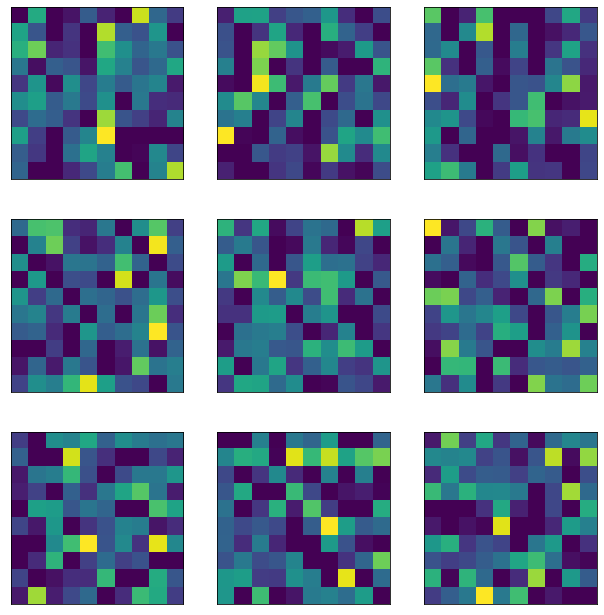

In [26]:
display_dictionary(W_true, dictionary_shape=(10, 10), save_name="images/dict_caltech30walk_dynamics_sync", figsize=[10,10])

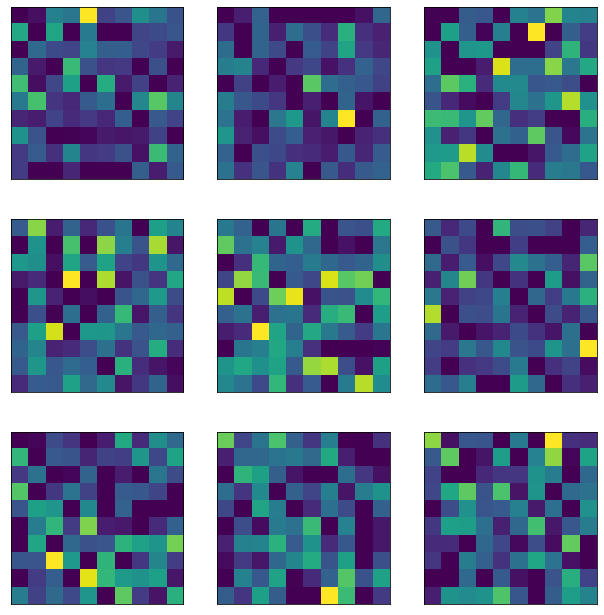

In [27]:
display_dictionary(W_false, dictionary_shape=(10, 10), save_name="images/dict_caltech30walk_dynamics_nonsync", figsize=[10,10])

In [144]:
pd.DataFrame(nx.adjacency_matrix(graph_list[249]).todense().flatten('C'))

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [145]:
df1 = pd.DataFrame()

for G in graph_list:
    temp = pd.DataFrame(np.array(nx.adjacency_matrix(G).todense().flatten('C')))
    df1 = df1.append(temp, ignore_index=True)
    
df1

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
246,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
247,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
248,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [146]:
df_adjmat = pd.concat([df1, df['Synchronized']], axis=1)

In [147]:
print(f"% of synchronized cases: {sum(df_adjmat['Synchronized'])/len(df_adjmat)}")

% of synchronized cases: 0.436


In [153]:
df_adjmat

,0,1,2,3,4,5,6,7,8,9,...,891,892,893,894,895,896,897,898,899,Synchronized
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,False
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,True
246,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,True
247,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
248,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False


In [160]:
X_true = df_adjmat[df_adjmat["Synchronized"] == 1].drop(['Synchronized'], axis=1)
X_false = df_adjmat[df_adjmat["Synchronized"] == 0].drop(['Synchronized'], axis=1)

In [162]:
X_false

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
244,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
247,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
248,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [163]:
X_true = X_true.values.astype('float32')
X_false = X_false.values.astype('float32')

In [168]:
W_true, H_true = ALS(X = X_true, 
           n_components = 9, # Reconstruction Error reduces as n_components increases
           n_iter = 100, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_true: {W_true.shape}\n###########################\n\n")

W_false, H_false = ALS(X = X_false, 
           n_components = 9, # Reconstruction Error reduces as n_components increases
           n_iter = 100, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_false: {W_false.shape}\n###########################\n\n")

 84%|█████████████████████████████▍     | 84/100 [00:00<00:00, 423.37it/s]

iteration 0, reconstruction error 21514.258517
iteration 10, reconstruction error 12105.125257
iteration 20, reconstruction error 11332.933454
iteration 30, reconstruction error 11085.910811
iteration 40, reconstruction error 10975.103738
iteration 50, reconstruction error 10909.800461
iteration 60, reconstruction error 10865.783624
iteration 70, reconstruction error 10834.515088
iteration 80, reconstruction error 10809.679984


100%|██████████████████████████████████| 100/100 [00:00<00:00, 402.56it/s]


iteration 90, reconstruction error 10788.775463


###########################
Shape of W_true: (109, 9)
###########################




 32%|███████████▏                       | 32/100 [00:00<00:00, 319.92it/s]

iteration 0, reconstruction error 26831.630046
iteration 10, reconstruction error 15338.654576
iteration 20, reconstruction error 14355.990704
iteration 30, reconstruction error 14067.320499
iteration 40, reconstruction error 13939.160289
iteration 50, reconstruction error 13865.318067


 64%|██████████████████████▍            | 64/100 [00:00<00:00, 285.56it/s]

iteration 60, reconstruction error 13812.395651


100%|██████████████████████████████████| 100/100 [00:00<00:00, 292.47it/s]

iteration 70, reconstruction error 13771.539578
iteration 80, reconstruction error 13739.063157
iteration 90, reconstruction error 13712.153909


###########################
Shape of W_false: (141, 9)
###########################




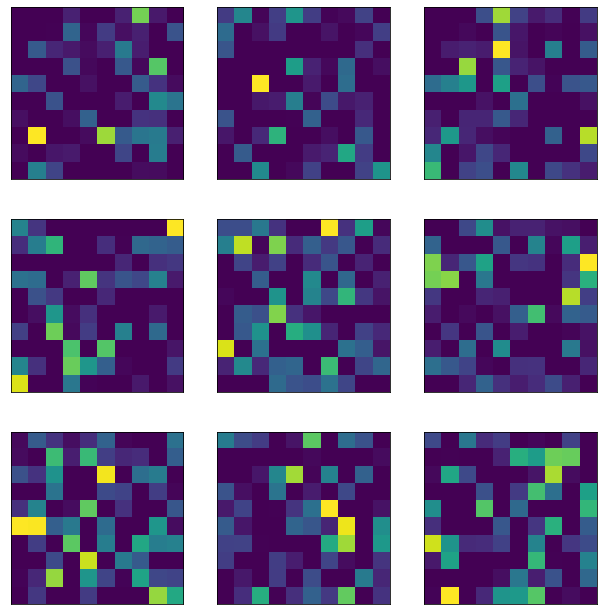

In [170]:
display_dictionary(W_true[:100,:], dictionary_shape=(10, 10), figsize=[10,10])

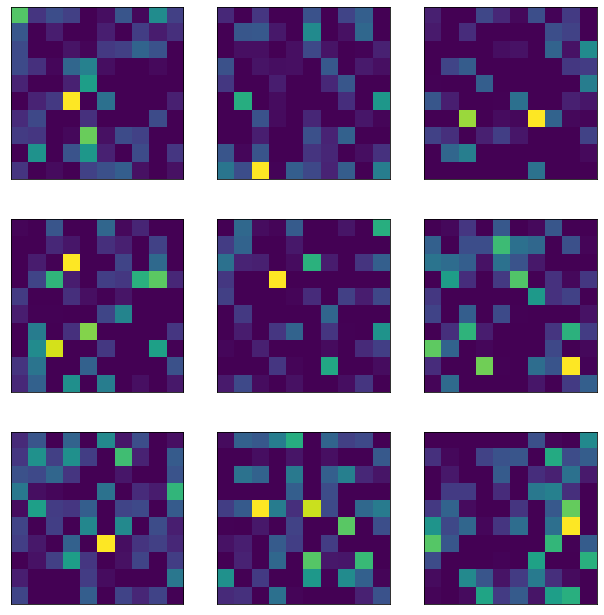

In [128]:
display_dictionary(W_false, dictionary_shape=(10, 10), save_name="images/dict_caltech30walk_adjmat_nonsync", figsize=[10,10])

In [172]:
df_ps = df.sample(n = 225)
print(f"% of synchronized cases: {sum(df_ps['Synchronized'])/len(df_ps)}")

% of synchronized cases: 0.4577777777777778


In [177]:
X = df_ps.drop(['# Edges', '# Nodes', 'Min Degree', 'Max Degree', 'Diameter', 'Synchronized'], axis=1).values.astype('float32')
X.shape

(225, 3750)

In [179]:
W, H = ALS(X = X, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W: {W.shape}\n###########################\n\n")

  2%|▌                                  | 16/1000 [00:00<00:11, 84.01it/s]

iteration 0, reconstruction error 10710160.573261
iteration 10, reconstruction error 3108537.800575
iteration 20, reconstruction error 2694533.393472


  5%|█▋                                | 50/1000 [00:00<00:09, 104.71it/s]

iteration 30, reconstruction error 1977056.445623
iteration 40, reconstruction error 1758344.275233
iteration 50, reconstruction error 1649157.346928


  7%|██▌                                | 72/1000 [00:00<00:09, 94.42it/s]

iteration 60, reconstruction error 1585824.841272
iteration 70, reconstruction error 1546149.148192


 10%|███▏                              | 95/1000 [00:00<00:08, 103.68it/s]

iteration 80, reconstruction error 1520209.586038
iteration 90, reconstruction error 1501881.525654
iteration 100, reconstruction error 1487647.324170


 13%|████▏                            | 128/1000 [00:01<00:08, 100.06it/s]

iteration 110, reconstruction error 1475988.760824
iteration 120, reconstruction error 1466102.566865


 15%|████▉                            | 150/1000 [00:01<00:08, 100.42it/s]

iteration 130, reconstruction error 1457563.424999
iteration 140, reconstruction error 1450242.243360
iteration 150, reconstruction error 1443873.776014


 17%|█████▊                            | 171/1000 [00:01<00:08, 97.68it/s]

iteration 160, reconstruction error 1438221.843767
iteration 170, reconstruction error 1433138.543874


 19%|██████▍                           | 190/1000 [00:02<00:11, 72.30it/s]

iteration 180, reconstruction error 1428528.816688
iteration 190, reconstruction error 1424318.402657


 21%|███████▏                          | 210/1000 [00:02<00:09, 83.19it/s]

iteration 200, reconstruction error 1420424.475111
iteration 210, reconstruction error 1416762.769403


 23%|███████▊                          | 228/1000 [00:02<00:10, 76.61it/s]

iteration 220, reconstruction error 1413287.590866
iteration 230, reconstruction error 1409987.166940


 25%|████████▌                         | 253/1000 [00:02<00:10, 70.95it/s]

iteration 240, reconstruction error 1406858.924947
iteration 250, reconstruction error 1403895.138869


 27%|█████████▏                        | 271/1000 [00:03<00:10, 68.02it/s]

iteration 260, reconstruction error 1401095.162922
iteration 270, reconstruction error 1398436.027490


 29%|█████████▉                        | 294/1000 [00:03<00:08, 86.35it/s]

iteration 280, reconstruction error 1395908.599417
iteration 290, reconstruction error 1393502.712881
iteration 300, reconstruction error 1391204.456548


 32%|██████████▉                       | 322/1000 [00:03<00:08, 83.98it/s]

iteration 310, reconstruction error 1389012.805426
iteration 320, reconstruction error 1386919.400861


 34%|███████████▌                      | 340/1000 [00:04<00:09, 70.05it/s]

iteration 330, reconstruction error 1384911.125085


 36%|████████████▍                     | 364/1000 [00:04<00:06, 91.93it/s]

iteration 340, reconstruction error 1382987.978114
iteration 350, reconstruction error 1381148.918951
iteration 360, reconstruction error 1379392.112464


 38%|█████████████                     | 385/1000 [00:04<00:06, 90.53it/s]

iteration 370, reconstruction error 1377713.908661
iteration 380, reconstruction error 1376113.968527


 41%|█████████████▊                    | 407/1000 [00:04<00:06, 95.63it/s]

iteration 390, reconstruction error 1374596.653512
iteration 400, reconstruction error 1373159.534574
iteration 410, reconstruction error 1371802.958409


 43%|██████████████▌                   | 427/1000 [00:04<00:06, 84.53it/s]

iteration 420, reconstruction error 1370528.901022
iteration 430, reconstruction error 1369344.285236


 46%|███████████████▌                  | 457/1000 [00:05<00:06, 89.90it/s]

iteration 440, reconstruction error 1368243.686599
iteration 450, reconstruction error 1367215.646011


 48%|███████████████▉                 | 484/1000 [00:05<00:04, 108.59it/s]

iteration 460, reconstruction error 1366249.139415
iteration 470, reconstruction error 1365337.504466
iteration 480, reconstruction error 1364475.626559


 51%|████████████████▊                | 510/1000 [00:05<00:04, 117.51it/s]

iteration 490, reconstruction error 1363656.387461
iteration 500, reconstruction error 1362874.043255
iteration 510, reconstruction error 1362122.485151


 53%|█████████████████▌               | 534/1000 [00:05<00:04, 111.66it/s]

iteration 520, reconstruction error 1361398.145243
iteration 530, reconstruction error 1360699.623284
iteration 540, reconstruction error 1360021.785405


 56%|██████████████████▍              | 559/1000 [00:06<00:03, 114.56it/s]

iteration 550, reconstruction error 1359360.783354
iteration 560, reconstruction error 1358714.073237


 58%|███████████████████▊              | 583/1000 [00:06<00:04, 96.76it/s]

iteration 570, reconstruction error 1358080.027495
iteration 580, reconstruction error 1357457.772587
iteration 590, reconstruction error 1356846.141928


 62%|████████████████████▍            | 621/1000 [00:06<00:03, 109.37it/s]

iteration 600, reconstruction error 1356244.055481
iteration 610, reconstruction error 1355651.944542
iteration 620, reconstruction error 1355069.118776


 65%|█████████████████████▎           | 646/1000 [00:06<00:03, 113.02it/s]

iteration 630, reconstruction error 1354495.526948
iteration 640, reconstruction error 1353930.129913
iteration 650, reconstruction error 1353372.955748


 68%|██████████████████████▌          | 683/1000 [00:07<00:02, 115.43it/s]

iteration 660, reconstruction error 1352824.326559
iteration 670, reconstruction error 1352283.368942
iteration 680, reconstruction error 1351751.062651


 71%|████████████████████████          | 706/1000 [00:07<00:03, 96.79it/s]

iteration 690, reconstruction error 1351227.104211
iteration 700, reconstruction error 1350711.913558


 73%|████████████████████████▋         | 726/1000 [00:07<00:03, 88.64it/s]

iteration 710, reconstruction error 1350205.470833
iteration 720, reconstruction error 1349706.767910


 75%|█████████████████████████▍        | 747/1000 [00:08<00:02, 90.77it/s]

iteration 730, reconstruction error 1349216.092110
iteration 740, reconstruction error 1348733.760484
iteration 750, reconstruction error 1348260.059902


 78%|█████████████████████████▊       | 781/1000 [00:08<00:02, 101.11it/s]

iteration 760, reconstruction error 1347794.520131
iteration 770, reconstruction error 1347338.342330
iteration 780, reconstruction error 1346893.026508


 80%|██████████████████████████▌      | 805/1000 [00:08<00:01, 108.99it/s]

iteration 790, reconstruction error 1346457.989575
iteration 800, reconstruction error 1346032.926888
iteration 810, reconstruction error 1345617.581569


 84%|███████████████████████████▊     | 842/1000 [00:08<00:01, 116.17it/s]

iteration 820, reconstruction error 1345211.620098
iteration 830, reconstruction error 1344814.449509
iteration 840, reconstruction error 1344425.732553


 87%|████████████████████████████▋    | 868/1000 [00:09<00:01, 110.52it/s]

iteration 850, reconstruction error 1344045.911793
iteration 860, reconstruction error 1343674.964366
iteration 870, reconstruction error 1343311.964813


 89%|█████████████████████████████▍   | 891/1000 [00:09<00:01, 107.07it/s]

iteration 880, reconstruction error 1342956.759735
iteration 890, reconstruction error 1342609.381773


 91%|███████████████████████████████   | 912/1000 [00:09<00:00, 92.15it/s]

iteration 900, reconstruction error 1342268.976586
iteration 910, reconstruction error 1341935.703396


 94%|██████████████████████████████▉  | 936/1000 [00:09<00:00, 102.07it/s]

iteration 920, reconstruction error 1341608.396774
iteration 930, reconstruction error 1341286.349113
iteration 940, reconstruction error 1340968.775827


 97%|████████████████████████████████ | 970/1000 [00:10<00:00, 103.05it/s]

iteration 950, reconstruction error 1340655.220008
iteration 960, reconstruction error 1340344.918852
iteration 970, reconstruction error 1340037.613059


100%|█████████████████████████████████| 1000/1000 [00:10<00:00, 95.51it/s]

iteration 980, reconstruction error 1339732.924192
iteration 990, reconstruction error 1339430.154343


###########################
Shape of W: (225, 16)
###########################




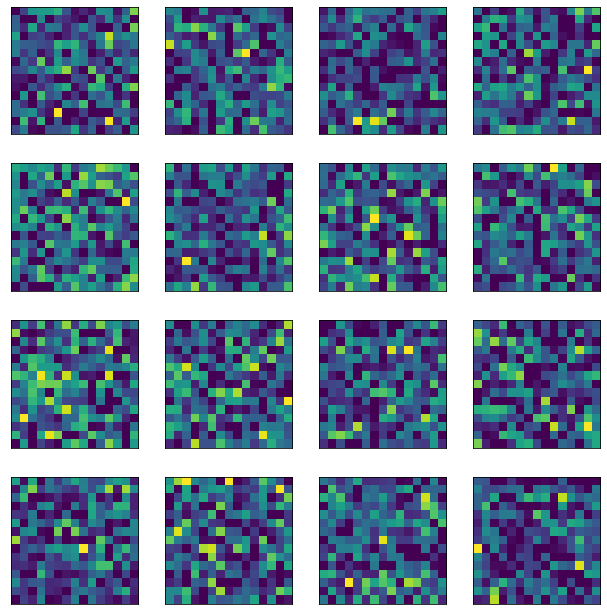

In [180]:
display_dictionary(W, figsize=[10,10])

In [181]:
sampling_alg = 'pivot'

ntwk = 'Caltech36' # COVID_PPI, Wisconsin87, UCLA26, Caltech36
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
save_folder = 'images/'
k = 50

path = "../Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

num nodes in G 769
num edges in G 33312


num of subgraphs induced on k-paths: 900
X.shape (2500, 900)


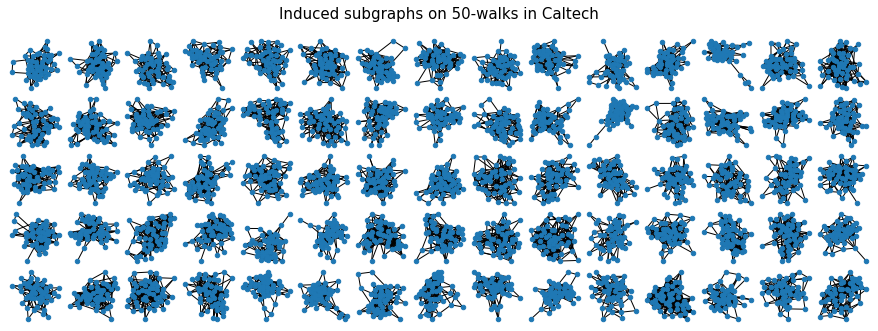

In [182]:
X, embs = G.get_patches(k=k, sample_size=900, skip_folded_hom=True)

display_graphs(title='Induced subgraphs on {}-walks in {}'.format(k, ntwk_nonumber),
                 save_path=save_folder + ntwk_nonumber + "_subgraphs_"+ str(sampling_alg) + "_walk", 
                 data = [X, embs],
                 grid_shape = [5, 15],
                 fig_size = [15, 5],
                 show_importance=False)

In [183]:
W, H = ALS(X=X, 
           n_components=16, # Reconstruction Error reduces as n_components increases
           n_iter=1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity=True,
           W_nonnegativity=True,
           compute_recons_error=True,
           subsample_ratio=1)

  1%|▎                                  | 10/1000 [00:00<00:22, 44.77it/s]

iteration 0, reconstruction error 427733.684669


  2%|▋                                  | 20/1000 [00:00<00:22, 44.19it/s]

iteration 10, reconstruction error 296325.925604


  2%|▉                                  | 25/1000 [00:00<00:23, 42.35it/s]

iteration 20, reconstruction error 294763.267453


  4%|█▍                                 | 40/1000 [00:00<00:23, 41.48it/s]

iteration 30, reconstruction error 288345.522830


  4%|█▌                                 | 45/1000 [00:01<00:23, 40.00it/s]

iteration 40, reconstruction error 275659.421832


  6%|█▉                                 | 57/1000 [00:01<00:21, 44.63it/s]

iteration 50, reconstruction error 270522.713367


  7%|██▎                                | 67/1000 [00:01<00:21, 44.14it/s]

iteration 60, reconstruction error 268061.297314


  8%|██▋                                | 77/1000 [00:01<00:22, 41.75it/s]

iteration 70, reconstruction error 266777.040950


  9%|███                                | 87/1000 [00:02<00:21, 42.43it/s]

iteration 80, reconstruction error 266053.822307


  9%|███▏                               | 92/1000 [00:02<00:21, 41.49it/s]

iteration 90, reconstruction error 265604.334311


 11%|███▋                              | 107/1000 [00:02<00:23, 38.67it/s]

iteration 100, reconstruction error 265295.778845


 12%|███▉                              | 115/1000 [00:02<00:23, 37.55it/s]

iteration 110, reconstruction error 265067.778958


 13%|████▍                             | 129/1000 [00:03<00:21, 40.82it/s]

iteration 120, reconstruction error 264888.280449


 14%|████▋                             | 139/1000 [00:03<00:21, 40.15it/s]

iteration 130, reconstruction error 264742.454247


 15%|█████                             | 149/1000 [00:03<00:21, 39.96it/s]

iteration 140, reconstruction error 264619.310322


 16%|█████▍                            | 159/1000 [00:03<00:19, 42.15it/s]

iteration 150, reconstruction error 264512.480963


 17%|█████▋                            | 169/1000 [00:04<00:19, 43.46it/s]

iteration 160, reconstruction error 264418.276808


 18%|██████                            | 179/1000 [00:04<00:18, 43.47it/s]

iteration 170, reconstruction error 264333.624239


 19%|██████▍                           | 189/1000 [00:04<00:21, 37.55it/s]

iteration 180, reconstruction error 264256.530899


 20%|██████▋                           | 197/1000 [00:04<00:21, 37.32it/s]

iteration 190, reconstruction error 264185.752863


 21%|███████                           | 206/1000 [00:05<00:20, 38.81it/s]

iteration 200, reconstruction error 264120.605521


 22%|███████▎                          | 215/1000 [00:05<00:20, 39.14it/s]

iteration 210, reconstruction error 264060.281583


 23%|███████▊                          | 230/1000 [00:05<00:18, 41.23it/s]

iteration 220, reconstruction error 264003.780683


 24%|███████▉                          | 235/1000 [00:05<00:19, 39.67it/s]

iteration 230, reconstruction error 263950.766105


 25%|████████▌                         | 250/1000 [00:06<00:17, 41.72it/s]

iteration 240, reconstruction error 263900.910510


 26%|████████▊                         | 260/1000 [00:06<00:17, 43.15it/s]

iteration 250, reconstruction error 263854.009932


 26%|█████████                         | 265/1000 [00:06<00:18, 40.72it/s]

iteration 260, reconstruction error 263809.801839


 28%|█████████▌                        | 280/1000 [00:06<00:17, 40.21it/s]

iteration 270, reconstruction error 263767.913511


 29%|█████████▊                        | 290/1000 [00:07<00:16, 41.77it/s]

iteration 280, reconstruction error 263728.182715


 30%|██████████▏                       | 300/1000 [00:07<00:16, 42.85it/s]

iteration 290, reconstruction error 263690.407207


 31%|██████████▌                       | 310/1000 [00:07<00:16, 42.47it/s]

iteration 300, reconstruction error 263654.281742


 32%|██████████▉                       | 320/1000 [00:07<00:15, 43.03it/s]

iteration 310, reconstruction error 263619.714447


 33%|███████████▏                      | 330/1000 [00:08<00:15, 43.25it/s]

iteration 320, reconstruction error 263586.585898


 34%|███████████▍                      | 335/1000 [00:08<00:15, 42.84it/s]

iteration 330, reconstruction error 263554.707922


 35%|███████████▊                      | 346/1000 [00:08<00:14, 45.60it/s]

iteration 340, reconstruction error 263524.003124


 36%|████████████                      | 356/1000 [00:08<00:14, 45.15it/s]

iteration 350, reconstruction error 263494.410310


 37%|████████████▍                     | 366/1000 [00:08<00:14, 45.00it/s]

iteration 360, reconstruction error 263465.850250


 38%|████████████▊                     | 376/1000 [00:09<00:14, 42.03it/s]

iteration 370, reconstruction error 263438.282061


 39%|█████████████                     | 386/1000 [00:09<00:14, 42.98it/s]

iteration 380, reconstruction error 263411.728436


 40%|█████████████▍                    | 396/1000 [00:09<00:13, 43.17it/s]

iteration 390, reconstruction error 263386.133116


 41%|█████████████▊                    | 406/1000 [00:09<00:14, 42.35it/s]

iteration 400, reconstruction error 263361.474177


 42%|██████████████▏                   | 416/1000 [00:10<00:14, 40.94it/s]

iteration 410, reconstruction error 263337.822911


 43%|██████████████▍                   | 426/1000 [00:10<00:13, 41.84it/s]

iteration 420, reconstruction error 263315.119422


 44%|██████████████▊                   | 436/1000 [00:10<00:13, 42.44it/s]

iteration 430, reconstruction error 263293.351990


 45%|███████████████▏                  | 446/1000 [00:10<00:12, 42.75it/s]

iteration 440, reconstruction error 263272.478264


 46%|███████████████▌                  | 456/1000 [00:11<00:12, 42.73it/s]

iteration 450, reconstruction error 263252.477858


 47%|███████████████▊                  | 466/1000 [00:11<00:12, 43.53it/s]

iteration 460, reconstruction error 263233.279009


 48%|████████████████▏                 | 476/1000 [00:11<00:12, 43.43it/s]

iteration 470, reconstruction error 263214.829859


 49%|████████████████▌                 | 486/1000 [00:11<00:11, 44.07it/s]

iteration 480, reconstruction error 263197.059372


 50%|████████████████▊                 | 496/1000 [00:11<00:11, 43.30it/s]

iteration 490, reconstruction error 263179.943921


 51%|█████████████████▏                | 506/1000 [00:12<00:11, 43.30it/s]

iteration 500, reconstruction error 263163.469666


 52%|█████████████████▌                | 516/1000 [00:12<00:11, 42.92it/s]

iteration 510, reconstruction error 263147.614318


 53%|█████████████████▉                | 526/1000 [00:12<00:11, 43.03it/s]

iteration 520, reconstruction error 263132.311285


 54%|██████████████████▏               | 536/1000 [00:12<00:10, 42.51it/s]

iteration 530, reconstruction error 263117.526373


 55%|██████████████████▌               | 546/1000 [00:13<00:10, 42.55it/s]

iteration 540, reconstruction error 263103.220973


 56%|██████████████████▉               | 556/1000 [00:13<00:11, 39.85it/s]

iteration 550, reconstruction error 263089.365003


 57%|███████████████████▏              | 566/1000 [00:13<00:10, 40.13it/s]

iteration 560, reconstruction error 263075.932107


 58%|███████████████████▌              | 576/1000 [00:13<00:09, 43.29it/s]

iteration 570, reconstruction error 263062.895875


 59%|███████████████████▉              | 586/1000 [00:14<00:09, 42.92it/s]

iteration 580, reconstruction error 263050.221875


 60%|████████████████████▎             | 596/1000 [00:14<00:09, 41.14it/s]

iteration 590, reconstruction error 263037.903169


 61%|████████████████████▌             | 606/1000 [00:14<00:10, 39.39it/s]

iteration 600, reconstruction error 263025.930831


 62%|█████████████████████             | 620/1000 [00:14<00:09, 41.36it/s]

iteration 610, reconstruction error 263014.278157


 62%|█████████████████████▎            | 625/1000 [00:15<00:09, 41.44it/s]

iteration 620, reconstruction error 263002.927871


 64%|█████████████████████▊            | 640/1000 [00:15<00:08, 42.07it/s]

iteration 630, reconstruction error 262991.882536


 64%|█████████████████████▉            | 645/1000 [00:15<00:08, 40.38it/s]

iteration 640, reconstruction error 262981.120904


 66%|██████████████████████▎           | 655/1000 [00:15<00:08, 41.67it/s]

iteration 650, reconstruction error 262970.611436


 66%|██████████████████████▌           | 665/1000 [00:16<00:08, 41.45it/s]

iteration 660, reconstruction error 262960.343281


 68%|███████████████████████           | 680/1000 [00:16<00:07, 41.86it/s]

iteration 670, reconstruction error 262950.318135


 69%|███████████████████████▍          | 690/1000 [00:16<00:07, 42.82it/s]

iteration 680, reconstruction error 262940.520240


 70%|███████████████████████▊          | 700/1000 [00:16<00:06, 44.01it/s]

iteration 690, reconstruction error 262930.924896


 70%|███████████████████████▉          | 705/1000 [00:17<00:07, 41.95it/s]

iteration 700, reconstruction error 262921.519892


 72%|████████████████████████▍         | 720/1000 [00:17<00:06, 43.19it/s]

iteration 710, reconstruction error 262912.302709


 72%|████████████████████████▋         | 725/1000 [00:17<00:06, 41.15it/s]

iteration 720, reconstruction error 262903.276278


 74%|█████████████████████████▏        | 740/1000 [00:17<00:05, 43.44it/s]

iteration 730, reconstruction error 262894.437829


 75%|█████████████████████████▌        | 750/1000 [00:18<00:05, 43.20it/s]

iteration 740, reconstruction error 262885.779660


 76%|█████████████████████████▊        | 760/1000 [00:18<00:05, 43.67it/s]

iteration 750, reconstruction error 262877.308654


 77%|██████████████████████████▏       | 770/1000 [00:18<00:05, 44.16it/s]

iteration 760, reconstruction error 262869.028780


 78%|██████████████████████████▎       | 775/1000 [00:18<00:05, 42.25it/s]

iteration 770, reconstruction error 262860.926176


 79%|██████████████████████████▊       | 790/1000 [00:18<00:04, 43.27it/s]

iteration 780, reconstruction error 262852.993212


 80%|███████████████████████████▏      | 800/1000 [00:19<00:04, 45.25it/s]

iteration 790, reconstruction error 262845.251113


 81%|███████████████████████████▌      | 810/1000 [00:19<00:04, 44.72it/s]

iteration 800, reconstruction error 262837.697539


 82%|███████████████████████████▉      | 820/1000 [00:19<00:04, 43.43it/s]

iteration 810, reconstruction error 262830.320213


 83%|████████████████████████████▏     | 830/1000 [00:19<00:03, 43.70it/s]

iteration 820, reconstruction error 262823.114428


 84%|████████████████████████████▌     | 840/1000 [00:20<00:03, 43.15it/s]

iteration 830, reconstruction error 262816.076072


 85%|████████████████████████████▉     | 850/1000 [00:20<00:03, 44.33it/s]

iteration 840, reconstruction error 262809.187008


 86%|█████████████████████████████▏    | 860/1000 [00:20<00:03, 43.04it/s]

iteration 850, reconstruction error 262802.436559


 87%|█████████████████████████████▌    | 870/1000 [00:20<00:03, 42.57it/s]

iteration 860, reconstruction error 262795.817458


 88%|█████████████████████████████▉    | 880/1000 [00:21<00:02, 44.13it/s]

iteration 870, reconstruction error 262789.325166


 89%|██████████████████████████████▎   | 890/1000 [00:21<00:02, 43.58it/s]

iteration 880, reconstruction error 262782.949321


 90%|██████████████████████████████▍   | 895/1000 [00:21<00:02, 42.07it/s]

iteration 890, reconstruction error 262776.693640


 91%|██████████████████████████████▉   | 910/1000 [00:21<00:02, 43.20it/s]

iteration 900, reconstruction error 262770.553040


 92%|███████████████████████████████▎  | 920/1000 [00:22<00:01, 41.95it/s]

iteration 910, reconstruction error 262764.522248


 93%|███████████████████████████████▌  | 930/1000 [00:22<00:01, 42.94it/s]

iteration 920, reconstruction error 262758.610623


 94%|███████████████████████████████▉  | 940/1000 [00:22<00:01, 44.14it/s]

iteration 930, reconstruction error 262752.818787


 95%|████████████████████████████████▎ | 950/1000 [00:22<00:01, 43.11it/s]

iteration 940, reconstruction error 262747.146770


 96%|████████████████████████████████▋ | 960/1000 [00:22<00:00, 44.38it/s]

iteration 950, reconstruction error 262741.582898


 96%|████████████████████████████████▊ | 965/1000 [00:23<00:00, 42.89it/s]

iteration 960, reconstruction error 262736.122303


 98%|█████████████████████████████████▏| 975/1000 [00:23<00:00, 39.69it/s]

iteration 970, reconstruction error 262730.766091


 99%|█████████████████████████████████▋| 989/1000 [00:23<00:00, 40.21it/s]

iteration 980, reconstruction error 262725.504292


 99%|█████████████████████████████████▊| 994/1000 [00:23<00:00, 32.31it/s]

iteration 990, reconstruction error 262720.328279


100%|█████████████████████████████████| 1000/1000 [00:24<00:00, 41.55it/s]


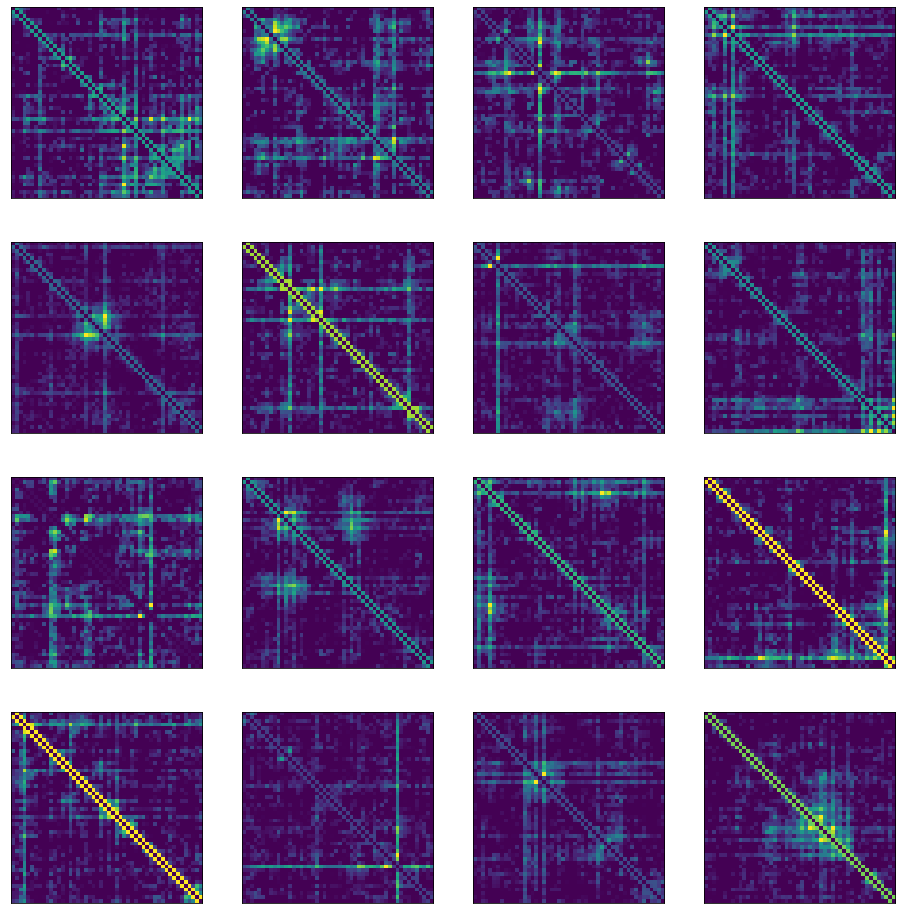

In [184]:
display_dictionary(W, figsize=[15,15])

In [186]:
def generate_nxg(get_patches_X):
    
    graph_list = []
    for i in range(X.shape[1]):
        adj_mat = X.T[i].reshape(50,50)
        G = nx.from_numpy_matrix(adj_mat)
        graph_list.append(G)
    
    return graph_list

def synchronization(colors):
    ordered = list(np.pi - colors); ordered.sort()
    lordered = len(ordered)
    
    threshold = np.pi
    if ordered == 0:
        assert("Empty array or logic error.")
    elif lordered == 1:
        return (0 < threshold)
    elif lordered == 2:
        dw = ordered[1]-ordered[0]
        if dw > threshold:
            return ((2*np.pi - dw) < threshold)
        else:
            return (dw < threshold)
    else:
        widths = [2*np.pi+ordered[0]-ordered[-1]]
        for i in range(lordered-1):
            widths.append(ordered[i+1]-ordered[i])
        return (np.abs(2*np.pi - max(widths)) < threshold)

In [187]:
graph_list = generate_nxg(X)
print(f"num of graphs: {len(graph_list)}")

num of graphs: 900


In [188]:
nodes = int(np.sqrt(X.shape[0]))
df = pd.DataFrame()
K = 2.5

for G in graph_list:
    
    headers = []
    for i in range(1, nodes+1):
        for j in range(1, r+1):
            headers.append(f's{i}_{j}')
        
    if nx.is_connected(G):

        adj_mat = nx.to_numpy_array(G)
        temp = pd.DataFrame(np.array(nx.adjacency_matrix(G).todense().flatten('C')))
        
        model = Kuramoto(coupling=K, dt=0.01, T=18, n_nodes=nodes, base_iter=r, half_sync=False)

        sim = model.run(adj_mat)
        arr = sim.T[-1]
        conc = pd.DataFrame(pd.Series(synchronization(arr)), columns=['Synchronized'])
            
        temp = pd.concat([temp, conc], axis=1)

        df = pd.concat([df, temp], ignore_index=True)
    
df

,0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,Synchronized
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,True
2,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,False
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,True
896,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,True
897,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,False
898,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,True


In [189]:
print(f"% of synchronized cases: {sum(df['Synchronized'])/len(df)}")

% of synchronized cases: 0.39111111111111113


In [192]:
X_true = df[df['Synchronized'] == True].drop(['Synchronized'], axis=1).values.astype('float32').T
X_false = df[df['Synchronized'] == False].drop(['Synchronized'], axis=1).values.astype('float32').T

In [193]:
print(X_true.shape)
print(X_false.shape)

(2500, 352)
(2500, 548)


In [194]:
W_true, H_true = ALS(X = X_true, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_true: {W_true.shape}\n###########################\n\n")

W_false, H_false = ALS(X = X_false, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_false: {W_false.shape}\n###########################\n\n")

  2%|▌                                  | 17/1000 [00:00<00:11, 86.32it/s]

iteration 0, reconstruction error 171801.448607
iteration 10, reconstruction error 118777.139674


  4%|█▎                                 | 37/1000 [00:00<00:10, 92.83it/s]

iteration 20, reconstruction error 116773.114135
iteration 30, reconstruction error 109833.799877


  6%|██                                 | 58/1000 [00:00<00:09, 98.96it/s]

iteration 40, reconstruction error 106795.927202
iteration 50, reconstruction error 105405.444807
iteration 60, reconstruction error 104692.303234


  9%|███                               | 91/1000 [00:00<00:08, 105.15it/s]

iteration 70, reconstruction error 104274.867714
iteration 80, reconstruction error 104000.602021
iteration 90, reconstruction error 103803.648702


 11%|███▋                             | 113/1000 [00:01<00:08, 100.44it/s]

iteration 100, reconstruction error 103653.379873
iteration 110, reconstruction error 103534.045561


 13%|████▌                             | 134/1000 [00:01<00:10, 84.99it/s]

iteration 120, reconstruction error 103436.795067
iteration 130, reconstruction error 103355.950257


 15%|█████▏                            | 152/1000 [00:01<00:10, 84.36it/s]

iteration 140, reconstruction error 103287.998779
iteration 150, reconstruction error 103229.818794


 17%|█████▊                            | 171/1000 [00:01<00:09, 87.99it/s]

iteration 160, reconstruction error 103179.278424
iteration 170, reconstruction error 103135.028478


 19%|██████▍                           | 191/1000 [00:02<00:08, 90.93it/s]

iteration 180, reconstruction error 103095.656764
iteration 190, reconstruction error 103060.497805
iteration 200, reconstruction error 103028.719644


 22%|███████▌                          | 223/1000 [00:02<00:08, 96.02it/s]

iteration 210, reconstruction error 102999.668282
iteration 220, reconstruction error 102973.030337


 24%|████████▎                         | 244/1000 [00:02<00:07, 95.97it/s]

iteration 230, reconstruction error 102948.597995
iteration 240, reconstruction error 102926.078623
iteration 250, reconstruction error 102905.203238


 28%|█████████                        | 276/1000 [00:02<00:07, 100.80it/s]

iteration 260, reconstruction error 102885.694826
iteration 270, reconstruction error 102867.438220


 29%|█████████▊                        | 287/1000 [00:03<00:08, 86.49it/s]

iteration 280, reconstruction error 102850.280711


 31%|██████████▌                       | 309/1000 [00:03<00:07, 87.82it/s]

iteration 290, reconstruction error 102834.105748
iteration 300, reconstruction error 102818.694562
iteration 310, reconstruction error 102804.061037


 34%|███████████▌                      | 340/1000 [00:03<00:07, 90.75it/s]

iteration 320, reconstruction error 102790.130860
iteration 330, reconstruction error 102776.781495


 35%|███████████▉                      | 350/1000 [00:03<00:07, 91.15it/s]

iteration 340, reconstruction error 102763.969342
iteration 350, reconstruction error 102751.703987


 38%|████████████▉                     | 380/1000 [00:04<00:06, 92.61it/s]

iteration 360, reconstruction error 102739.970381
iteration 370, reconstruction error 102728.672939
iteration 380, reconstruction error 102717.841944


 40%|█████████████▋                    | 402/1000 [00:04<00:06, 97.66it/s]

iteration 390, reconstruction error 102707.442451
iteration 400, reconstruction error 102697.399428
iteration 410, reconstruction error 102687.643003


 43%|██████████████▎                  | 434/1000 [00:04<00:05, 103.68it/s]

iteration 420, reconstruction error 102678.159797
iteration 430, reconstruction error 102668.921464
iteration 440, reconstruction error 102659.888260


 46%|███████████████▊                  | 464/1000 [00:05<00:06, 84.48it/s]

iteration 450, reconstruction error 102651.093314
iteration 460, reconstruction error 102642.543551


 48%|████████████████▍                 | 482/1000 [00:05<00:06, 83.37it/s]

iteration 470, reconstruction error 102634.270560
iteration 480, reconstruction error 102626.248949


 50%|█████████████████                 | 501/1000 [00:05<00:05, 85.05it/s]

iteration 490, reconstruction error 102618.450541
iteration 500, reconstruction error 102610.848063
iteration 510, reconstruction error 102603.421004


 53%|██████████████████                | 532/1000 [00:05<00:05, 89.50it/s]

iteration 520, reconstruction error 102596.154680
iteration 530, reconstruction error 102589.102081
iteration 540, reconstruction error 102582.246489


 56%|███████████████████▏              | 565/1000 [00:06<00:04, 96.56it/s]

iteration 550, reconstruction error 102575.596788
iteration 560, reconstruction error 102569.121694


 58%|███████████████████▉              | 585/1000 [00:06<00:04, 93.56it/s]

iteration 570, reconstruction error 102562.791179
iteration 580, reconstruction error 102556.572238


 61%|████████████████████▋             | 607/1000 [00:06<00:03, 99.79it/s]

iteration 590, reconstruction error 102550.477469
iteration 600, reconstruction error 102544.490829
iteration 610, reconstruction error 102538.580322


 64%|█████████████████████▋            | 638/1000 [00:06<00:03, 90.89it/s]

iteration 620, reconstruction error 102532.734579
iteration 630, reconstruction error 102526.965307


 66%|██████████████████████▎           | 658/1000 [00:07<00:03, 92.01it/s]

iteration 640, reconstruction error 102521.251613
iteration 650, reconstruction error 102515.589772


 68%|███████████████████████           | 679/1000 [00:07<00:03, 96.52it/s]

iteration 660, reconstruction error 102509.996012
iteration 670, reconstruction error 102504.469902
iteration 680, reconstruction error 102499.030713


 71%|████████████████████████          | 709/1000 [00:07<00:03, 89.27it/s]

iteration 690, reconstruction error 102493.653746
iteration 700, reconstruction error 102488.323242


 73%|████████████████████████▊         | 729/1000 [00:07<00:02, 91.30it/s]

iteration 710, reconstruction error 102483.024497
iteration 720, reconstruction error 102477.798662
iteration 730, reconstruction error 102472.642134


 76%|█████████████████████████▊        | 760/1000 [00:08<00:02, 94.79it/s]

iteration 740, reconstruction error 102467.538694
iteration 750, reconstruction error 102462.477589


 78%|██████████████████████████▌       | 780/1000 [00:08<00:02, 87.87it/s]

iteration 760, reconstruction error 102457.464074
iteration 770, reconstruction error 102452.487091


 79%|██████████████████████████▊       | 789/1000 [00:08<00:02, 81.50it/s]

iteration 780, reconstruction error 102447.534881
iteration 790, reconstruction error 102442.645487


 82%|███████████████████████████▊      | 819/1000 [00:08<00:02, 87.62it/s]

iteration 800, reconstruction error 102437.829031
iteration 810, reconstruction error 102433.106613


 84%|████████████████████████████▍     | 837/1000 [00:09<00:01, 86.72it/s]

iteration 820, reconstruction error 102428.454467
iteration 830, reconstruction error 102423.869524


 86%|█████████████████████████████     | 855/1000 [00:09<00:01, 82.18it/s]

iteration 840, reconstruction error 102419.345325
iteration 850, reconstruction error 102414.897569


 88%|█████████████████████████████▊    | 877/1000 [00:09<00:01, 93.25it/s]

iteration 860, reconstruction error 102410.515351
iteration 870, reconstruction error 102406.194696
iteration 880, reconstruction error 102401.932471


 91%|█████████████████████████████▉   | 909/1000 [00:09<00:00, 100.03it/s]

iteration 890, reconstruction error 102397.738708
iteration 900, reconstruction error 102393.615315
iteration 910, reconstruction error 102389.560882


 94%|███████████████████████████████▉  | 941/1000 [00:10<00:00, 98.80it/s]

iteration 920, reconstruction error 102385.574786
iteration 930, reconstruction error 102381.649291
iteration 940, reconstruction error 102377.810593


 96%|████████████████████████████████▋ | 961/1000 [00:10<00:00, 94.23it/s]

iteration 950, reconstruction error 102374.053816
iteration 960, reconstruction error 102370.369875


 98%|█████████████████████████████████▎| 981/1000 [00:10<00:00, 92.27it/s]

iteration 970, reconstruction error 102366.761924
iteration 980, reconstruction error 102363.220595


100%|█████████████████████████████████| 1000/1000 [00:10<00:00, 91.49it/s]


iteration 990, reconstruction error 102359.755455


###########################
Shape of W_true: (2500, 16)
###########################




  1%|▏                                   | 6/1000 [00:00<00:19, 51.69it/s]

iteration 0, reconstruction error 255906.509527


  2%|▋                                  | 20/1000 [00:00<00:17, 55.46it/s]

iteration 10, reconstruction error 176957.034276
iteration 20, reconstruction error 175248.336156


  4%|█▍                                 | 41/1000 [00:00<00:15, 61.90it/s]

iteration 30, reconstruction error 168359.454330
iteration 40, reconstruction error 161896.324153


  6%|██▏                                | 62/1000 [00:01<00:15, 62.00it/s]

iteration 50, reconstruction error 159491.250892
iteration 60, reconstruction error 158278.434001


  8%|██▉                                | 83/1000 [00:01<00:14, 64.32it/s]

iteration 70, reconstruction error 157644.079067
iteration 80, reconstruction error 157264.138731


 10%|███▍                               | 99/1000 [00:01<00:12, 70.59it/s]

iteration 90, reconstruction error 157011.067657
iteration 100, reconstruction error 156826.808631


 12%|████▏                             | 124/1000 [00:01<00:12, 71.85it/s]

iteration 110, reconstruction error 156683.553102
iteration 120, reconstruction error 156567.623863


 14%|████▋                             | 139/1000 [00:02<00:12, 67.05it/s]

iteration 130, reconstruction error 156470.510843
iteration 140, reconstruction error 156387.439442


 16%|█████▍                            | 161/1000 [00:02<00:12, 66.08it/s]

iteration 150, reconstruction error 156314.923555
iteration 160, reconstruction error 156250.996491


 18%|██████▏                           | 183/1000 [00:02<00:11, 68.34it/s]

iteration 170, reconstruction error 156193.985261
iteration 180, reconstruction error 156142.282406


 20%|██████▉                           | 205/1000 [00:03<00:11, 69.80it/s]

iteration 190, reconstruction error 156094.951941
iteration 200, reconstruction error 156051.362185


 22%|███████▍                          | 220/1000 [00:03<00:12, 62.63it/s]

iteration 210, reconstruction error 156011.151705
iteration 220, reconstruction error 155973.798876


 24%|████████▎                         | 243/1000 [00:03<00:10, 70.44it/s]

iteration 230, reconstruction error 155938.675040
iteration 240, reconstruction error 155905.579469


 26%|████████▊                         | 259/1000 [00:03<00:10, 71.30it/s]

iteration 250, reconstruction error 155874.261370
iteration 260, reconstruction error 155844.522245


 28%|█████████▌                        | 283/1000 [00:04<00:09, 72.80it/s]

iteration 270, reconstruction error 155816.368822
iteration 280, reconstruction error 155789.636394


 30%|██████████▏                       | 299/1000 [00:04<00:10, 69.61it/s]

iteration 290, reconstruction error 155764.224562
iteration 300, reconstruction error 155740.027649


 32%|██████████▉                       | 321/1000 [00:04<00:11, 57.75it/s]

iteration 310, reconstruction error 155717.069069
iteration 320, reconstruction error 155695.150598


 34%|███████████▋                      | 345/1000 [00:05<00:09, 66.60it/s]

iteration 330, reconstruction error 155674.122252
iteration 340, reconstruction error 155654.014457


 36%|████████████▏                     | 360/1000 [00:05<00:09, 68.05it/s]

iteration 350, reconstruction error 155634.810704
iteration 360, reconstruction error 155616.360683


 38%|████████████▉                     | 381/1000 [00:05<00:10, 60.64it/s]

iteration 370, reconstruction error 155598.660495
iteration 380, reconstruction error 155581.630833


 40%|█████████████▍                    | 396/1000 [00:06<00:09, 61.41it/s]

iteration 390, reconstruction error 155565.263092
iteration 400, reconstruction error 155549.537413


 42%|██████████████▏                   | 419/1000 [00:06<00:08, 67.27it/s]

iteration 410, reconstruction error 155534.336030
iteration 420, reconstruction error 155519.627578


 44%|███████████████                   | 442/1000 [00:06<00:08, 69.10it/s]

iteration 430, reconstruction error 155505.399756
iteration 440, reconstruction error 155491.662356


 46%|███████████████▌                  | 458/1000 [00:07<00:07, 69.65it/s]

iteration 450, reconstruction error 155478.351482
iteration 460, reconstruction error 155465.437216


 48%|████████████████▎                 | 481/1000 [00:07<00:07, 67.19it/s]

iteration 470, reconstruction error 155452.956358
iteration 480, reconstruction error 155440.888208


 50%|█████████████████                 | 502/1000 [00:07<00:07, 63.08it/s]

iteration 490, reconstruction error 155429.170444
iteration 500, reconstruction error 155417.787049


 52%|█████████████████▌                | 516/1000 [00:07<00:08, 60.34it/s]

iteration 510, reconstruction error 155406.774296
iteration 520, reconstruction error 155396.082626


 54%|██████████████████▍               | 544/1000 [00:08<00:07, 63.29it/s]

iteration 530, reconstruction error 155385.709538
iteration 540, reconstruction error 155375.679623


 56%|███████████████████               | 559/1000 [00:08<00:06, 67.12it/s]

iteration 550, reconstruction error 155365.955888
iteration 560, reconstruction error 155356.520744


 58%|███████████████████▊              | 582/1000 [00:08<00:05, 70.33it/s]

iteration 570, reconstruction error 155347.370681
iteration 580, reconstruction error 155338.487761


 61%|████████████████████▌             | 606/1000 [00:09<00:05, 71.82it/s]

iteration 590, reconstruction error 155329.873174
iteration 600, reconstruction error 155321.515489


 62%|█████████████████████▏            | 623/1000 [00:09<00:05, 71.68it/s]

iteration 610, reconstruction error 155313.427957
iteration 620, reconstruction error 155305.614638


 64%|█████████████████████▊            | 641/1000 [00:09<00:04, 77.86it/s]

iteration 630, reconstruction error 155298.068315
iteration 640, reconstruction error 155290.781880


 66%|██████████████████████▎           | 658/1000 [00:09<00:04, 78.92it/s]

iteration 650, reconstruction error 155283.746201
iteration 660, reconstruction error 155276.966806


 68%|███████████████████████▏          | 682/1000 [00:10<00:04, 69.31it/s]

iteration 670, reconstruction error 155270.412000
iteration 680, reconstruction error 155264.068507


 70%|███████████████████████▋          | 698/1000 [00:10<00:04, 66.86it/s]

iteration 690, reconstruction error 155257.935744
iteration 700, reconstruction error 155252.022617


 72%|████████████████████████▍         | 719/1000 [00:10<00:04, 61.35it/s]

iteration 710, reconstruction error 155246.306396
iteration 720, reconstruction error 155240.783802


 74%|█████████████████████████▏        | 741/1000 [00:11<00:04, 62.80it/s]

iteration 730, reconstruction error 155235.439746
iteration 740, reconstruction error 155230.260180


 76%|█████████████████████████▊        | 759/1000 [00:11<00:03, 72.41it/s]

iteration 750, reconstruction error 155225.235751
iteration 760, reconstruction error 155220.360238


 78%|██████████████████████████▌       | 782/1000 [00:11<00:03, 64.30it/s]

iteration 770, reconstruction error 155215.621539
iteration 780, reconstruction error 155211.005585


 80%|███████████████████████████       | 796/1000 [00:12<00:03, 54.16it/s]

iteration 790, reconstruction error 155206.501506


 81%|███████████████████████████▌      | 812/1000 [00:12<00:02, 63.40it/s]

iteration 800, reconstruction error 155202.100373
iteration 810, reconstruction error 155197.799703


 83%|████████████████████████████▏     | 828/1000 [00:12<00:02, 68.55it/s]

iteration 820, reconstruction error 155193.598812
iteration 830, reconstruction error 155189.496328


 85%|████████████████████████████▉     | 851/1000 [00:13<00:02, 68.77it/s]

iteration 840, reconstruction error 155185.490778
iteration 850, reconstruction error 155181.569879


 87%|█████████████████████████████▌    | 868/1000 [00:13<00:02, 64.71it/s]

iteration 860, reconstruction error 155177.725607
iteration 870, reconstruction error 155173.955561


 89%|██████████████████████████████▎   | 890/1000 [00:13<00:01, 67.31it/s]

iteration 880, reconstruction error 155170.252081
iteration 890, reconstruction error 155166.611986


 92%|███████████████████████████████   | 915/1000 [00:13<00:01, 72.39it/s]

iteration 900, reconstruction error 155163.032222
iteration 910, reconstruction error 155159.520939


 93%|███████████████████████████████▋  | 932/1000 [00:14<00:00, 73.85it/s]

iteration 920, reconstruction error 155156.074655
iteration 930, reconstruction error 155152.686342


 95%|████████████████████████████████▎ | 949/1000 [00:14<00:00, 77.16it/s]

iteration 940, reconstruction error 155149.364522
iteration 950, reconstruction error 155146.101280


 97%|█████████████████████████████████ | 972/1000 [00:14<00:00, 63.20it/s]

iteration 960, reconstruction error 155142.890028
iteration 970, reconstruction error 155139.731358


 99%|█████████████████████████████████▊| 994/1000 [00:15<00:00, 64.32it/s]

iteration 980, reconstruction error 155136.623975
iteration 990, reconstruction error 155133.557554


100%|█████████████████████████████████| 1000/1000 [00:15<00:00, 65.79it/s]



###########################
Shape of W_false: (2500, 16)
###########################




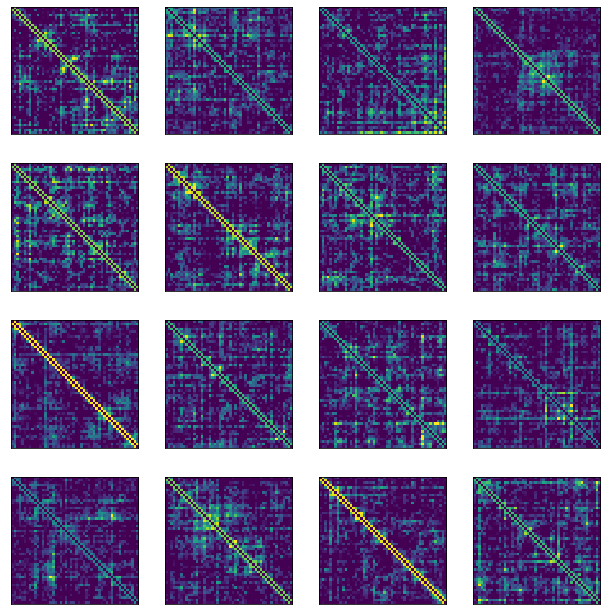

In [195]:
display_dictionary(W_true, figsize=[10,10])

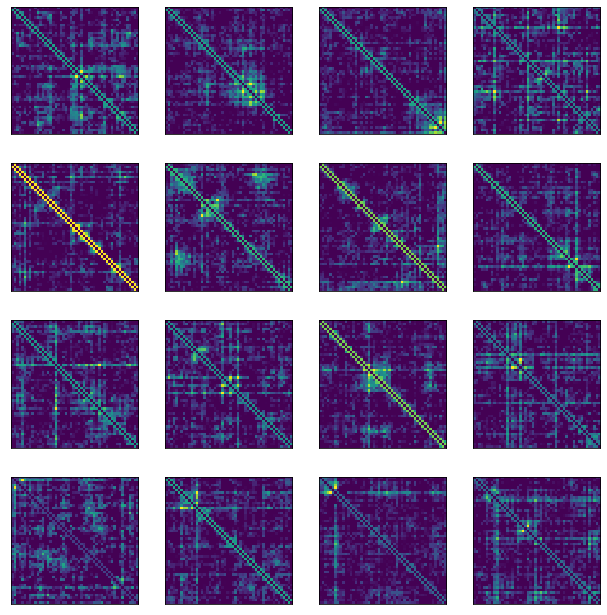

In [196]:
display_dictionary(W_false, figsize=[10,10])